In [1]:
import cv2
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LSTM, SimpleRNN
from keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras import layers, models, optimizers
import keras
# from tensorflow.keras.applications import EfficientNetB0, VGG16
from tensorflow.keras import * 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import io
from tensorflow.keras.models import Model 
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, Xception, EfficientNetB0, EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
# from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import sklearn
from tensorflow.keras.metrics import Precision, Recall
# from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess


2025-06-05 01:27:08.926906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749086829.115728      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749086829.180215      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_data_dir = '/kaggle/input/classifying-ad-and-pd-v3/3_cls_2/train'
test_data_dir = '/kaggle/input/classifying-ad-and-pd-v3/3_cls_2/test'
image_size = (224, 224)
image_size2 = (600, 600) # EfficientNetB7
batch_size = 16


In [3]:
train_datagen = ImageDataGenerator(
        preprocessing_function=effnet_preprocess,
        rotation_range=20,     #Random rotation between 0 and 45
        width_shift_range=0.2,   #% shift
        brightness_range=[0.8, 1.2],      # New: Random brightness
        channel_shift_range=10.,          # New: Channel shift
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='constant', 
        cval=125,
        # rescale=1.0/255.0,
        validation_split=0.1  # 20% of the data will be used for validation
    ) 
val_datagen = ImageDataGenerator(
    preprocessing_function=effnet_preprocess,
    validation_split=0.1
)
test_datagen = ImageDataGenerator(preprocessing_function=effnet_preprocess,)

In [4]:
# Create ImageDataGenerators for training and validation with data augmentation
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Use the 'training' subset
)

# Load the validation data
validation_generator = val_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use the 'validation' subset
) 


# Load the data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)
###################### EfficientNetB7
batch_size = 8 
# Create ImageDataGenerators for training and validation with data augmentation
train_generator2 = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size2,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Use the 'training' subset
)

# Load the validation data
validation_generator2 = val_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size2,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use the 'validation' subset
) 


# Load the data
test_generator2 = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size2,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 5646 images belonging to 3 classes.
Found 626 images belonging to 3 classes.
Found 1567 images belonging to 3 classes.
Found 5646 images belonging to 3 classes.
Found 626 images belonging to 3 classes.
Found 1567 images belonging to 3 classes.


In [5]:
X_train, y_train = next(train_generator)
X_val, y_val = next(validation_generator)
X_test, y_test = next(test_generator)

In [6]:
total = 0
for class_name in os.listdir(train_data_dir):
    class_path = os.path.join(train_data_dir, class_name)
    if os.path.isdir(class_path):
        n = len([fname for fname in os.listdir(class_path)
                 if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
        print(f"{class_name}: {n} images")
        total += n
print(f"Total images before augmentation: {total}")

CONTROL: 2938 images
PD: 774 images
AD: 2560 images
Total images before augmentation: 6272


In [7]:
print(f"Train images used (after augmentation): {train_generator.samples}")

Train images used (after augmentation): 5646


In [21]:
def unfreeze_top_blocks(base_model, model_name):
    for layer in base_model.layers:
        layer.trainable = False  # Freeze all first

    if model_name == 'VGG16':
        for layer in base_model.layers:
            if layer.name.startswith('block5_') or layer.name.startswith('block4_'):
                layer.trainable = True
    elif model_name == 'ResNet50':
        for layer in base_model.layers:
            if layer.name.startswith('conv5_') or layer.name.startswith('conv4_'):
                layer.trainable = True
    elif model_name == 'InceptionV3':
        for layer in base_model.layers:
            if 'mixed7' in layer.name or 'mixed8' in layer.name or 'mixed9' in layer.name:
                layer.trainable = True
    elif model_name == 'Xception':
        for layer in base_model.layers:
            if 'block13' in layer.name or 'block14' in layer.name:
                layer.trainable = True
    elif model_name == 'EfficientNetB7' or model_name == 'EfficientNetB0':
        for layer in base_model.layers:
            if 'block6' in layer.name or 'block7' in layer.name:
                layer.trainable = True

## Note: new and old functions below 

I created a new **"build_and_train_model()"** function but also left the old one (just extended the name with "_old") below. The new function does the 2 step process of training and also freezes 80% of the layers of each model - allowing you to fine-tune 20% of the layers. You could always change this to get more specific with each model, but this is a solid generalized approach that I think works. 

In [26]:
initial_epochs= 10
def build_and_train_model_two_phase(
    model_name,
    base_model,
    train_generator,
    validation_generator,
    initial_epochs=initial_epochs,      # train head for 5–10 epochs
    fine_tune_epochs= 80,   # then fine-tune for approx 10–15 more (or even more than that?)
    initial_lr=1e-4,
    fine_tune_lr=3e-5,
    dropout_rate=0.7
):
    """
    Two-phase training:
      Phase 1: Freeze ~80% of base_model, train only head for initial_epochs.
      Phase 2: Unfreeze last blocks of base_model, recompile with lower LR, continue training.
    Returns: (fine-tuned_model, combined_history)
    """

    # -----------------------------------------------------------
    # STEP A: Freeze most of the base_model for Phase 1
    # -----------------------------------------------------------
    # 1) freeze the earliest 60 % of layers in base_model.
    print("here1")
    for layer in base_model.layers:
        layer.trainable = False

    # now - base_model has 80% of its layers frozen, 20% trainable!

    # -----------------------------------------------------------
    # STEP B: Build & compile the full model (head + base)
    # -----------------------------------------------------------
    print("here2")
    x = Flatten()(base_model.output)                        # Flatten the feature map
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)                    # One hidden Dense layer
    x = Dropout(dropout_rate)(x)                            # Dropout for regularization
    output = Dense(3, activation='softmax')(x)              # 3-way softmax for AD/PD/Control

    model = Model(inputs=base_model.input, outputs=output)

    # Compile with a “standard” learning rate for the head (Phase 1)
    print("here3")
    model.compile(
        optimizer=Adam(learning_rate=initial_lr),
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(), Recall()]
    )

    # -----------------------------------------------------------
    # STEP C: Compute class_weights 
    # -----------------------------------------------------------
    print("here4")
    classes = train_generator.classes
    unique_classes = np.unique(classes)  # e.g. array([0,1,2])

    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=classes
    )
    class_weights = dict(zip(unique_classes, weights))
    
    # -----------------------------------------------------------
    # STEP D: Phase 1 — Train only the head (base_model is mostly frozen)
    # -----------------------------------------------------------
   # Learning rate reducer
    print("here5")
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        min_lr=1e-7,
        verbose=2
    )

    # Early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=12,    
        restore_best_weights=True,
        verbose=2
    )
    print(">>> PHASE 1: Training head (with ~80% of base frozen) <<<")
    print("here6")
    history_phase1 = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples // train_generator.batch_size,
        validation_data   = validation_generator,
        validation_steps  = validation_generator.samples // validation_generator.batch_size,
        epochs            = initial_epochs,
        callbacks         = [reduce_lr, early_stop],
        class_weight      = class_weights,
        verbose           = 2
    )


    # -----------------------------------------------------------
    # STEP E: Phase 2 — Unfreeze the final blocks of base_model
    # -----------------------------------------------------------
    print("\n>>> PHASE 2: Fine-tuning top layers <<<")
    
    # (a) Freeze everything again first, then unfreeze only the final blocks by name/index.
    for layer in base_model.layers:
        layer.trainable = False
    unfreeze_top_blocks(base_model, model_name)
    # ** Here is where you unfreeze only the “last blocks” (approx 20% of layers) **
    # You can either do: 
    #   (1) Replace the condition below with the exact block‐name rule for your architecture.
    #   For example, if this is ResNet50, you might do:
    #       if layer.name.startswith('conv5_') or layer.name.startswith('conv4_'): layer.trainable=True
    #
    #   -or- 
    #   (2) for simplicity - we’ll unfreeze everything from index N onward again:
     
    # (b) recompile with a lower learning rate (to avoid wrecking the pretrained weights)
    model.compile(
        optimizer=Adam(learning_rate=fine_tune_lr),
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(), Recall()]
    )

    # (c) continue training (starting from where Phase 1 left off) - with same class_weight
    history_phase2 = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples // train_generator.batch_size,
        validation_data = validation_generator,
        validation_steps = validation_generator.samples // validation_generator.batch_size,
        epochs = initial_epochs + fine_tune_epochs,
        initial_epoch = initial_epochs,  # resume from Phase 1
        callbacks = [reduce_lr, early_stop],
        class_weight = class_weights,
        verbose = 2
    )
   
    # -----------------------------------------------------------
    # STEP F: Combine the histories so we can plot later if desired
    # -----------------------------------------------------------
    combined_history = {
        'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
        'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss'],
        'accuracy': history_phase1.history.get('accuracy', []) + history_phase2.history.get('accuracy', []),
        'val_accuracy': history_phase1.history.get('val_accuracy', []) + history_phase2.history.get('val_accuracy', []),
        'precision': history_phase1.history.get('precision', []) + history_phase2.history.get('precision', []),
        'val_precision': history_phase1.history.get('val_precision', []) + history_phase2.history.get('val_precision', []),
        'recall': history_phase1.history.get('recall', []) + history_phase2.history.get('recall', []),
        'val_recall': history_phase1.history.get('val_recall', []) + history_phase2.history.get('val_recall', []),
    }

    return model, combined_history

In [10]:
def build_and_train_model_old(base_model, train_generator, validation_generator, epochs=50,learning_rate=0.0001, dropout_rate=0.5):
    # Freeze the convolutional base
    # base_model.trainable = False
    # for layer in base_model.layers:
    #     layer.trainable = False 
    N = 3
    for layer in base_model.layers[:N]:
        layer.trainable = False
    for layer in base_model.layers[N:]:
        layer.trainable = True

    # Add custom classification layers
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(3, activation='softmax')(x)  # 3 classes: Alzheimer's, Parkinson's, Control

    # Create the model
    model = Model(inputs=base_model.input, outputs=output)
    
    # Compile the model
    learning_rate1 = float(1e-4)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate1),
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(), Recall()]
    )
     

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',    # or 'val_accuracy'
        factor=0.5,            # reduce by half
        patience=3,            # wait this many epochs with no improvement
        min_lr=1e-7,           # never lower than this
        verbose=1
    )

    from sklearn.utils import class_weight
    import numpy as np
    

    classes = train_generator.classes
    class_labels = np.unique(classes)
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=class_labels,
        y=classes
    )
    class_weights = dict(zip(class_labels, weights))
    
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_steps=validation_generator.samples // batch_size,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[reduce_lr],
        class_weight=class_weights   # <-- singular
    )
    return model, history


In [11]:
from tensorflow.keras.callbacks import Callback

class TerminateOnMetric(Callback):
    def __init__(self, monitor='accuracy', threshold=0.80):
        super().__init__()
        self.monitor = monitor
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        metric_value = logs.get(self.monitor)
        if metric_value is not None:
            if metric_value >= self.threshold:
                print(f"\nReached {self.monitor} = {metric_value:.4f}, stopping training!")
                self.model.stop_training = True

# Example usage:
callback = TerminateOnMetric(monitor='accuracy', threshold=0.80)
 

In [28]:
 pretrained_models = {
    'VGG16': VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet', pooling='avg'),
    'ResNet50': ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet', pooling='avg'),
    'InceptionV3': InceptionV3(include_top=False, input_shape=(224, 224, 3), weights='imagenet', pooling='avg'),
    'Xception': Xception(include_top=False, input_shape=(224, 224, 3), weights='imagenet', pooling='avg'),
    'EfficientNetB0': EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet', pooling='avg'),
    'EfficientNetB7': EfficientNetB7(include_top=False, input_shape=(600, 600, 3), weights='imagenet', pooling='avg'),
    
}

# Store the trained models and their histories
trained_models = {}
histories = {}

for model_name, base_model in pretrained_models.items():
    print(f"Training model: {model_name}")
    if (model_name == 'EfficientNetB7'): model, history = build_and_train_model_two_phase(model_name, base_model, train_generator2, validation_generator2)
    if (model_name != 'EfficientNetB7'): model, history = build_and_train_model_two_phase(model_name, base_model, train_generator, validation_generator)
    trained_models[model_name] = model
    histories[model_name] = history


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Training model: VGG16
here1
here2
here3
here4
here5
>>> PHASE 1: Training head (with ~80% of base frozen) <<<
here6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
352/352 - 84s - 240ms/step - accuracy: 0.4909 - loss: 2.8609 - precision_8: 0.4921 - recall_8: 0.4869 - val_accuracy: 0.6378 - val_loss: 1.0897 - val_precision_8: 0.6378 - val_recall_8: 0.6378 - learning_rate: 1.0000e-04
Epoch 2/2


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


352/352 - 2s - 5ms/step - accuracy: 0.5000 - loss: 1.2526 - precision_8: 0.5333 - recall_8: 0.5000 - val_accuracy: 0.6410 - val_loss: 1.0889 - val_precision_8: 0.6410 - val_recall_8: 0.6410 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 2.

>>> PHASE 2: Fine-tuning top layers <<<
Epoch 3/4
352/352 - 88s - 251ms/step - accuracy: 0.5892 - loss: 1.0077 - precision_9: 0.5956 - recall_9: 0.5538 - val_accuracy: 0.6442 - val_loss: 0.8817 - val_precision_9: 0.6418 - val_recall_9: 0.6346 - learning_rate: 3.0000e-05
Epoch 4/4
352/352 - 2s - 5ms/step - accuracy: 0.6875 - loss: 0.6962 - precision_9: 0.7143 - recall_9: 0.6250 - val_accuracy: 0.6394 - val_loss: 0.8930 - val_precision_9: 0.6387 - val_recall_9: 0.6346 - learning_rate: 3.0000e-05
Restoring model weights from the end of the best epoch: 3.
Training model: EfficientNetB7
here1
here2
here3
here4
here5
>>> PHASE 1: Training head (with ~80% of base frozen) <<<
here6
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


705/705 - 618s - 877ms/step - accuracy: 0.5986 - loss: 1.0383 - precision_10: 0.6113 - recall_10: 0.5511 - val_accuracy: 0.6779 - val_loss: 0.9283 - val_precision_10: 0.6786 - val_recall_10: 0.6699 - learning_rate: 1.0000e-04
Epoch 2/2


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


705/705 - 20s - 28ms/step - accuracy: 0.6250 - loss: 0.9260 - precision_10: 0.6250 - recall_10: 0.6250 - val_accuracy: 0.6731 - val_loss: 0.9286 - val_precision_10: 0.6753 - val_recall_10: 0.6667 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.

>>> PHASE 2: Fine-tuning top layers <<<
Epoch 3/4


E0000 00:00:1749089337.879919     136 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749089338.149636     136 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749089405.753174     136 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749089406.022770     136 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


705/705 - 735s - 1s/step - accuracy: 0.6940 - loss: 0.8807 - precision_11: 0.7030 - recall_11: 0.6674 - val_accuracy: 0.7147 - val_loss: 0.9574 - val_precision_11: 0.7143 - val_recall_11: 0.7131 - learning_rate: 3.0000e-05
Epoch 4/4
705/705 - 21s - 29ms/step - accuracy: 0.6250 - loss: 0.8815 - precision_11: 0.6250 - recall_11: 0.6250 - val_accuracy: 0.7179 - val_loss: 0.9500 - val_precision_11: 0.7191 - val_recall_11: 0.7179 - learning_rate: 3.0000e-05
Restoring model weights from the end of the best epoch: 4.


In [29]:
 def evaluate_model(model, test_generator):
    # Evaluate the model
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-2)
    
    # Predict the classes for validation data
    test_preds = model.predict(test_generator)
    test_preds = np.argmax(test_preds, axis=1)
    test_true = test_generator.classes
    
    # Generate confusion matrix
    cm = confusion_matrix(test_true, test_preds)
    
    return test_accuracy, test_precision, test_recall, test_f1, cm

results = []
test_accuracies = []
for model_name, model in trained_models.items():
    print(f"Evaluating model: {model_name}")
    if (model_name != 'EfficientNetB7'): test_accuracy, test_precision, test_recall, test_f1, cm = evaluate_model(model, test_generator)
    if (model_name == 'EfficientNetB7'): test_accuracy, test_precision, test_recall, test_f1, cm = evaluate_model(model, test_generator2)
    results.append({
        'Model': model_name,
        'Accuracy': test_accuracy,
        'Precision': test_precision,
        'Recall': test_recall,
        'F1 Score': test_f1,
        'Confusion Matrix': cm
    })
    test_accuracies.append(test_accuracy)

print(results)

Evaluating model: VGG16
98/98 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.5771 - loss: 1.0040 - precision_9: 0.5788 - recall_9: 0.5724
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step
Evaluating model: EfficientNetB7


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


196/196 ━━━━━━━━━━━━━━━━━━━━ 61s 311ms/step - accuracy: 0.6192 - loss: 1.0864 - precision_11: 0.6206 - recall_11: 0.5983
196/196 ━━━━━━━━━━━━━━━━━━━━ 86s 338ms/step
[{'Model': 'VGG16', 'Accuracy': 0.5666879415512085, 'Precision': 0.5680933594703674, 'Recall': 0.5590299963951111, 'F1 Score': 0.5585695290817259, 'Confusion Matrix': array([[ 52, 477, 111],
       [ 56, 534, 144],
       [ 15, 150,  28]])}, {'Model': 'EfficientNetB7', 'Accuracy': 0.6279515027999878, 'Precision': 0.6299734711647034, 'Recall': 0.606253981590271, 'F1 Score': 0.6129281205377791, 'Confusion Matrix': array([[465,  83,  92],
       [537, 106,  91],
       [139,  30,  24]])}]



=== Model: VGG16 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Image: /kaggle/input/classifying-ad-and-pd-v3/3_cls_2/train/AD/AD_10.png
Predicted class: CONTROL (index: 1), Probabilities: [0.3084182 0.466986  0.2245957]


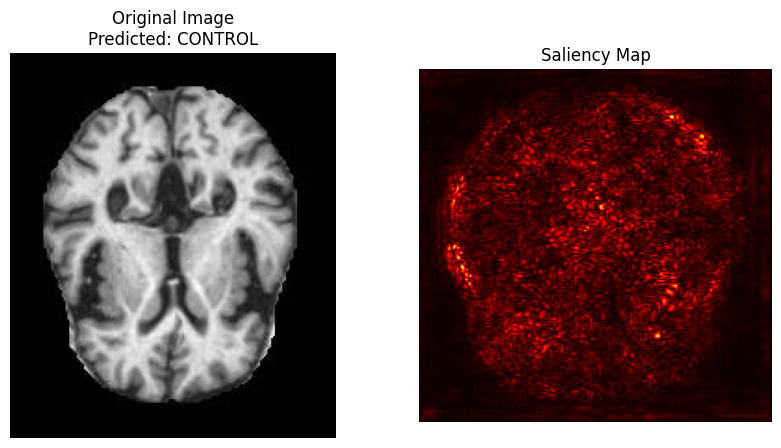

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image: /kaggle/input/classifying-ad-and-pd-v3/3_cls_2/train/CONTROL/CONTROLAD_10.png
Predicted class: CONTROL (index: 1), Probabilities: [0.31907582 0.45649233 0.22443184]


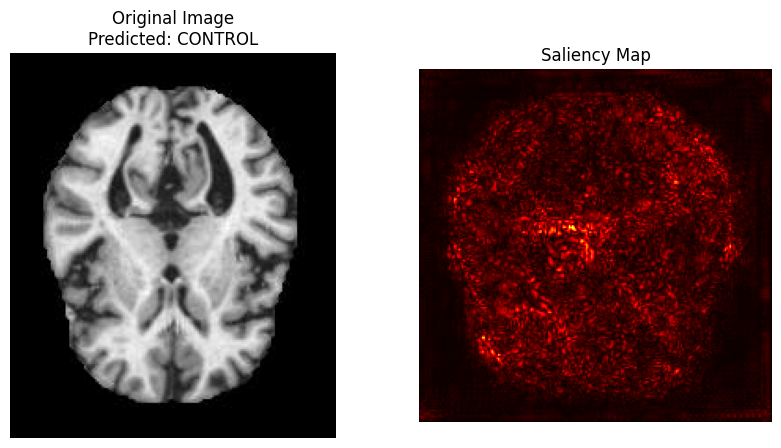

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image: /kaggle/input/classifying-ad-and-pd-v3/3_cls_2/train/PD/PD_10.png
Predicted class: CONTROL (index: 1), Probabilities: [0.28908932 0.408541   0.30236977]


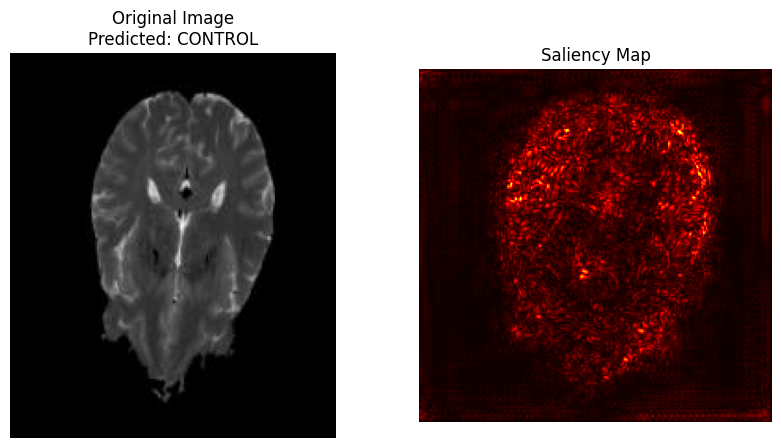


=== Model: EfficientNetB7 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Image: /kaggle/input/classifying-ad-and-pd-v3/3_cls_2/train/AD/AD_10.png
Predicted class: PD (index: 2), Probabilities: [0.27054352 0.36319384 0.36626264]


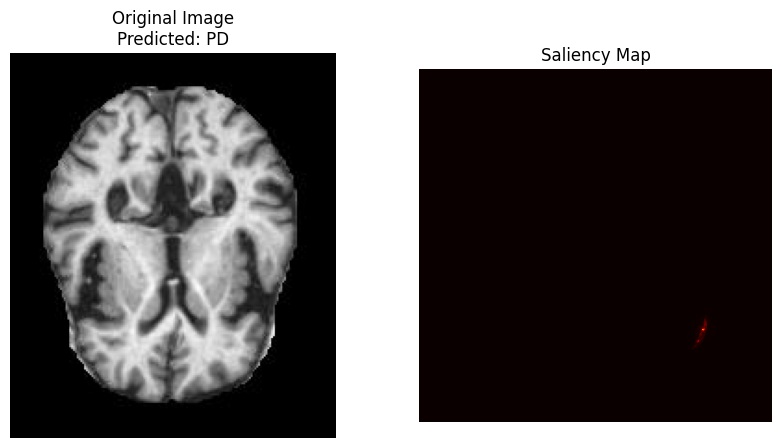

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Image: /kaggle/input/classifying-ad-and-pd-v3/3_cls_2/train/CONTROL/CONTROLAD_10.png
Predicted class: PD (index: 2), Probabilities: [0.27036196 0.3645013  0.36513674]


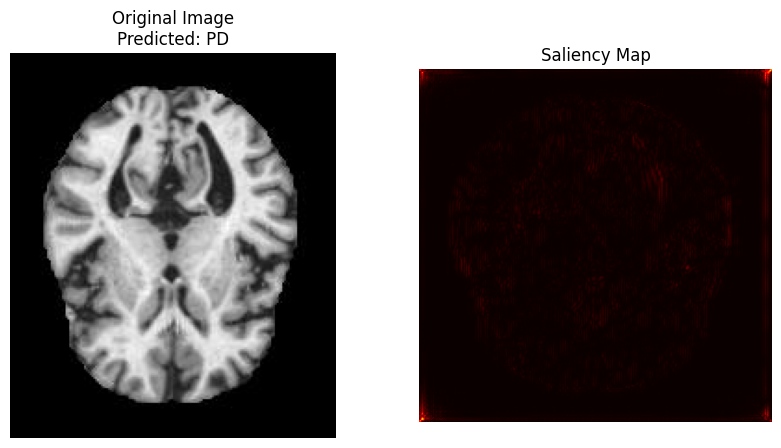

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Image: /kaggle/input/classifying-ad-and-pd-v3/3_cls_2/train/PD/PD_10.png
Predicted class: CONTROL (index: 1), Probabilities: [0.2705325  0.3651292  0.36433828]


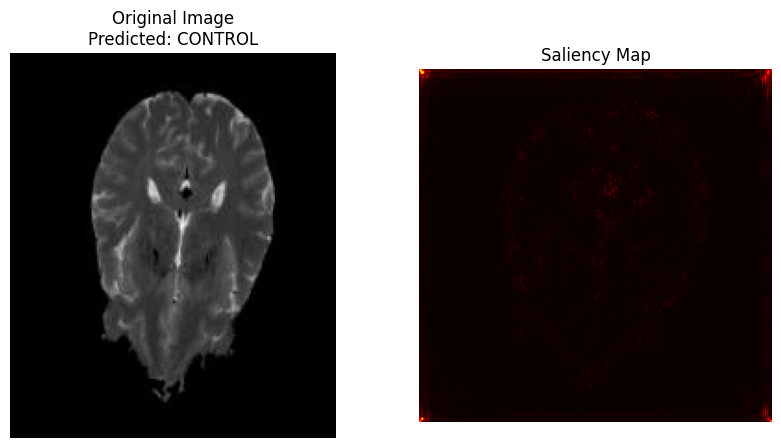

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Example: replace with your actual class order
class_names = ['AD', 'CONTROL', 'PD']

def generate_saliency_map(model, img_path, class_idx, image_size=(224, 224)):
    img = load_img(img_path, target_size=image_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize the image

    import tensorflow as tf
    with tf.GradientTape() as tape:
        inputs = tf.cast(img_array, tf.float32)
        tape.watch(inputs)
        predictions = model(inputs)
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, inputs)
    abs_grads = tf.abs(grads)
    saliency = tf.reduce_max(abs_grads, axis=-1)
    saliency = saliency[0]
    saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency) + 1e-10)
    return saliency

def plot_saliency_map(img_path, saliency, predicted_class_name):
    img = load_img(img_path)
    img = np.array(img)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f'Original Image\nPredicted: {predicted_class_name}')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(saliency, cmap='hot')
    plt.title('Saliency Map')
    plt.axis('off')
    plt.show()

# Example test images (replace with your own paths)
test_images = [
    '/kaggle/input/classifying-ad-and-pd-v3/3_cls_2/train/AD/AD_10.png',
    '/kaggle/input/classifying-ad-and-pd-v3/3_cls_2/train/CONTROL/CONTROLAD_10.png',
    '/kaggle/input/classifying-ad-and-pd-v3/3_cls_2/train/PD/PD_10.png'
]

image_size = (224, 224)  # or your input size

# for model_name, model in trained_models.items():
#     print(f"\n=== Model: {model_name} ===")
#     for img_path in test_images:
#         if (model_name != 'EfficientNetB7'): img_arr = img_to_array(load_img(img_path, target_size=image_size)).reshape(1, 224, 224, 3) / 255.0
#         if (model_name == 'EfficientNetB7'): img_arr = img_to_array(load_img(img_path, target_size=image_size2)).reshape(1, 600, 600, 3) / 255.0
#         preds = model.predict(img_arr)
#         predicted_class_idx = np.argmax(preds[0])
#         predicted_class_name = class_names[predicted_class_idx]
#         print(f"Image: {img_path}")
#         print(f"Predicted class: {predicted_class_name} (index: {predicted_class_idx}), Probabilities: {preds[0]}")
#         saliency = generate_saliency_map(model, img_path, predicted_class_idx, image_size=image_size)
#         plot_saliency_map(img_path, saliency, predicted_class_name)

for model_name, model in trained_models.items():
    print(f"\n=== Model: {model_name} ===")
    for img_path in test_images:
        if model_name == 'EfficientNetB7':
            curr_size = image_size2  # (600, 600)
        else:
            curr_size = image_size   # (224, 224)
        img_arr = img_to_array(load_img(img_path, target_size=curr_size))
        img_arr = np.expand_dims(img_arr, axis=0) / 255.0

        preds = model.predict(img_arr)
        predicted_class_idx = np.argmax(preds[0])
        predicted_class_name = class_names[predicted_class_idx]
        print(f"Image: {img_path}")
        print(f"Predicted class: {predicted_class_name} (index: {predicted_class_idx}), Probabilities: {preds[0]}")

        saliency = generate_saliency_map(model, img_path, predicted_class_idx, image_size=curr_size)
        plot_saliency_map(img_path, saliency, predicted_class_name)

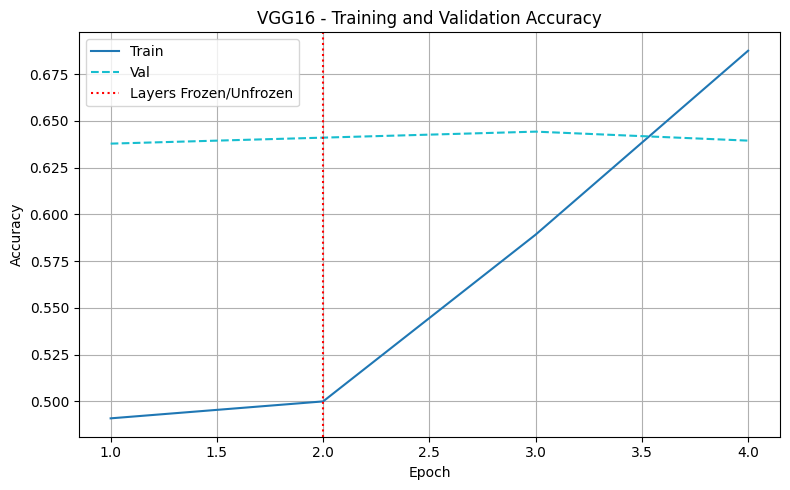

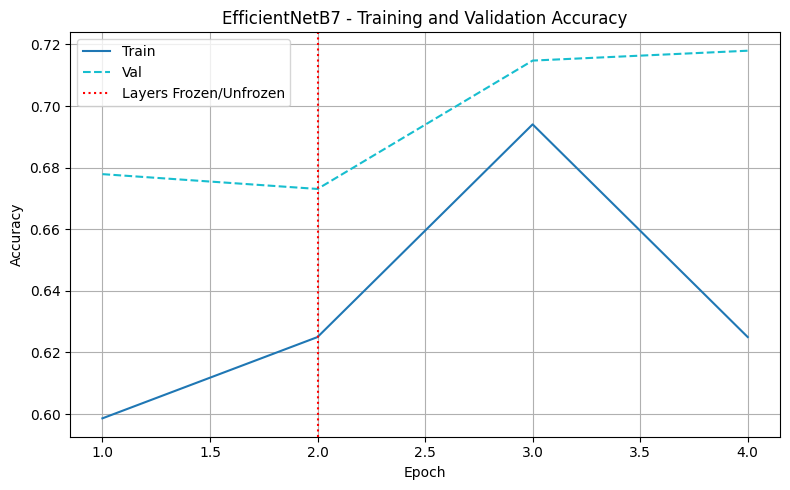

In [38]:
import matplotlib.pyplot as plt

def plot_each_model_accuracy(histories, initial_epochs=None):
    """
    Plots training and validation accuracy for each model in separate figures.

    Args:
        histories (dict): Keys are model names, values are Keras History.history dicts.
        initial_epochs (int or None): If provided, draws a vertical line at this epoch.
    """
    for model_name, history in histories.items():
        acc = history.get('accuracy') or history.get('acc')
        val_acc = history.get('val_accuracy') or history.get('val_acc')
        epochs = range(1, len(acc) + 1)

        plt.figure(figsize=(8, 5))
        plt.plot(epochs, acc, label="Train", color='tab:blue', linestyle='-')
        plt.plot(epochs, val_acc, label="Val", color='tab:cyan', linestyle='--')
        if initial_epochs is not None:
            plt.axvline(x=initial_epochs, linestyle=':', color='red', label='Layers Frozen/Unfrozen')
        plt.title(f"{model_name} - Training and Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Usage:
plot_each_model_accuracy(histories, initial_epochs=initial_epochs)
# If you don't have initial_epochs, just call: plot_each_model_accuracy(histories)

Highest test accuracy: 0.6280 (ResNet50)


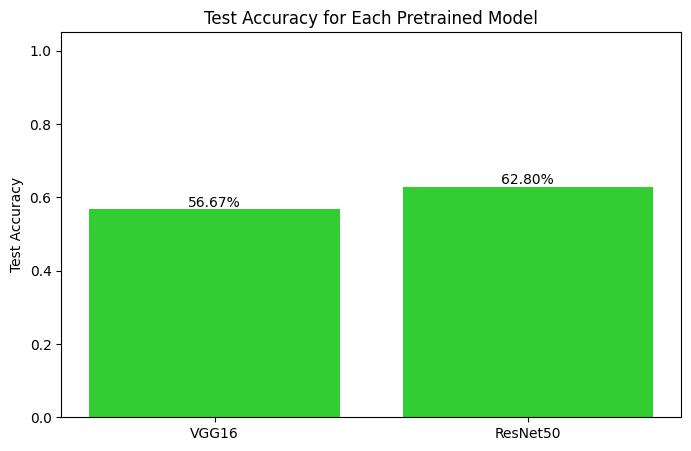

In [40]:
import matplotlib.pyplot as plt

# Example model names in order
model_names = ['VGG16', 'ResNet50', 'InceptionV3', 'Xception', 'EfficientNetB0','EfficientNetB7']
 
# Your test_accuracies list
# test_accuracies = [0.81, 0.85, 0.83, 0.80, 0.88]  # Example

# Find the index (and name) of the model with the highest accuracy
best_index = max(range(len(test_accuracies)), key=lambda i: test_accuracies[i])
best_accuracy = test_accuracies[best_index]
best_model = model_names[best_index]
print(f"Highest test accuracy: {best_accuracy:.4f} ({best_model})")

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, test_accuracies, color='limegreen')
plt.ylabel("Test Accuracy")
plt.ylim(0, 1.05)
plt.title("Test Accuracy for Each Pretrained Model")
for bar, acc in zip(bars, test_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{acc:.2%}", 
             ha='center', va='bottom', fontsize=10)
plt.show()